── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“There were 343 warnings in `mutate()`.
The first warning was:
ℹ In argument: `Gene = paste(...)`.
ℹ In row 0.
Caused by warning:
! There was 1 warning in `filter()`.
ℹ In argument: `&...`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 342 remaining warnings.”


Analysis complete. Results saved to 'significant_regions_with_genes.csv'.


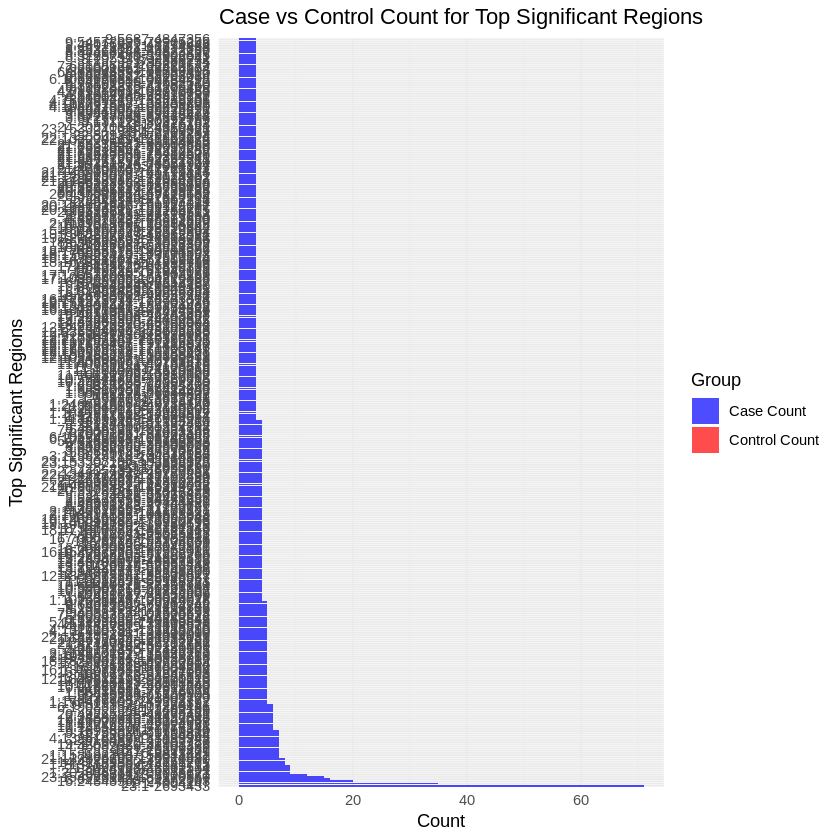

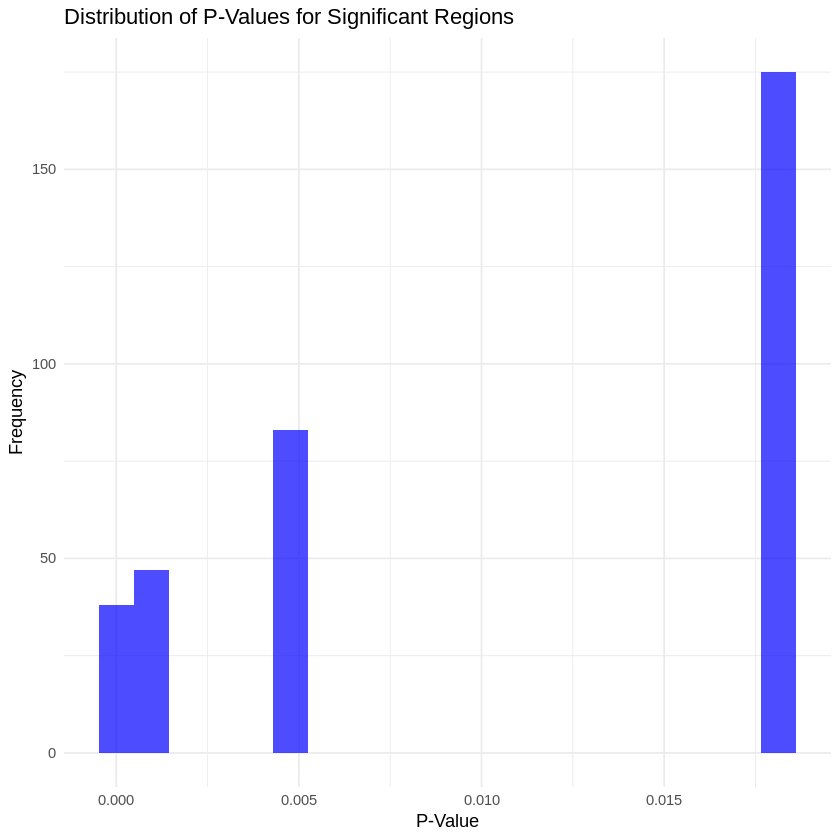

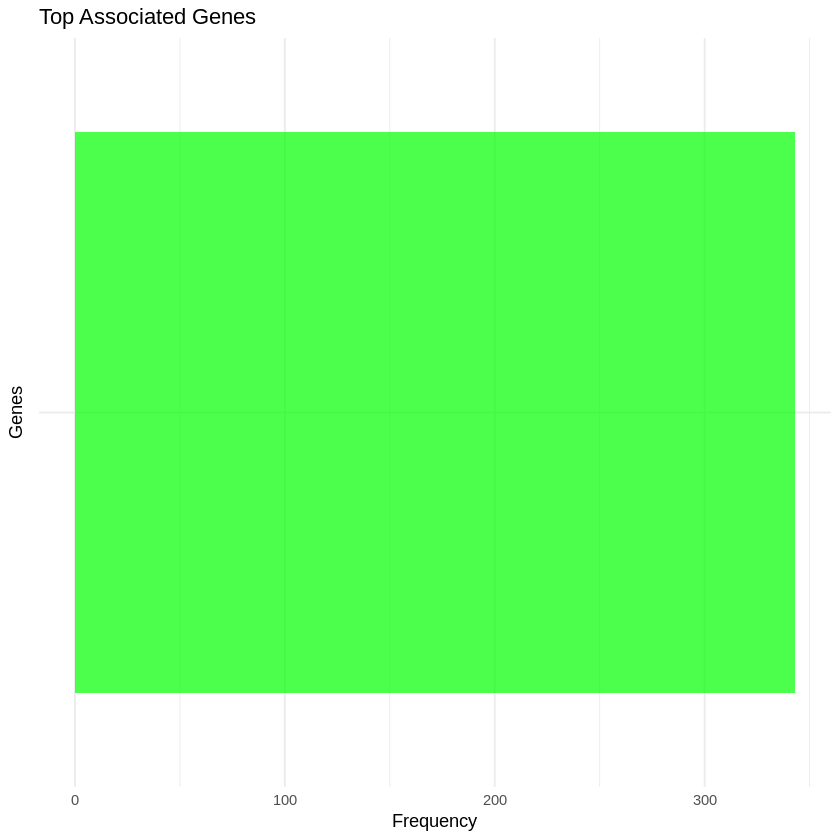

In [4]:
# Load required libraries
library(tidyverse)
library(dplyr)
library(ggplot2)
library(stats)

# Load the datasets
case_data <- read.csv("PC_case.csv", stringsAsFactors = FALSE)
control_data <- read.csv("PC_control.csv", stringsAsFactors = FALSE)
gene_data <- read.csv("geneList.csv", stringsAsFactors = FALSE)

# Rename columns for clarity
colnames(case_data) <- c("Chromosome", "Start", "End", "Type", "Patient_ID")
colnames(control_data) <- c("Chromosome", "Start", "End", "Type", "Patient_ID")
colnames(gene_data) <- c("Gene_ID", "Unused", "Chromosome", "Gene_Start", "Gene_End")

# Drop unused column in gene_list
gene_list <- gene_data %>% select(-Unused)

# Add a label column to distinguish between cases and controls
case_data$Label <- 1
control_data$Label <- 0

# Combine the datasets
data <- bind_rows(case_data, control_data)

# Feature engineering: Extract key features
data <- data %>%
  mutate(Length = End - Start)

# Encode categorical variables (Type) as dummy variables
data <- data %>%
  mutate(Type = as.factor(Type)) %>%
  model.matrix(~ Type - 1, data = .) %>%
  as.data.frame() %>%
  bind_cols(data)

# Convert Chromosome to a numeric factor
data$Chromosome <- as.numeric(factor(data$Chromosome))

# Add a Region column for chromosomal regions
data <- data %>%
  mutate(Region = paste0(Chromosome, ":", Start, "-", End))

# Group by regions and labels, calculate frequencies
region_stats <- data %>%
  group_by(Region, Label) %>%
  summarise(Count = n(), .groups = "drop") %>%
  pivot_wider(names_from = Label, values_from = Count, values_fill = 0) %>%
  rename(Control_Count = `0`, Case_Count = `1`) %>%
  mutate(Total = Control_Count + Case_Count,
         Case_Frequency = Case_Count / Total,
         Control_Frequency = Control_Count / Total)

# Perform Fisher's Exact Test for each region
region_stats <- region_stats %>%
  rowwise() %>%
  mutate(P_Value = fisher.test(matrix(c(Case_Count, Control_Count,
                                        sum(region_stats$Case_Count) - Case_Count,
                                        sum(region_stats$Control_Count) - Control_Count),
                                      nrow = 2))$p.value)

# Filter significant regions (e.g., P-Value < 0.05)
significant_regions <- region_stats %>%
  filter(P_Value < 0.05)

# Map significant regions to genes
map_to_genes <- function(region_stats, gene_list) {
  significant_genes <- region_stats %>%
    rowwise() %>%
    mutate(
      Gene = paste(
        gene_list %>%
          filter(Chromosome == as.numeric(str_split(Region, ":")[[1]][1]) &
                   Gene_Start <= as.numeric(str_split(Region, "[-]")[[1]][2]) &
                   Gene_End >= as.numeric(str_split(Region, ":")[[1]][2])) %>%
          pull(Gene_ID),
        collapse = ","
      )
    )
  return(significant_genes)
}

significant_regions_with_genes <- map_to_genes(significant_regions, gene_list)

# Save results
write.csv(significant_regions_with_genes, "significant_regions_with_genes.csv", row.names = FALSE)
cat("Analysis complete. Results saved to 'significant_regions_with_genes.csv'.\n")

# Visualization

# Top significant regions (Case vs Control Counts)
top_regions <- significant_regions %>%
  arrange(desc(Case_Count)) %>%
  slice_head(n = 10)

ggplot(top_regions, aes(x = reorder(Region, -Case_Count))) +
  geom_bar(aes(y = Case_Count, fill = "Case Count"), stat = "identity", alpha = 0.7) +
  geom_bar(aes(y = Control_Count, fill = "Control Count"), stat = "identity", alpha = 0.7) +
  labs(x = "Top Significant Regions", y = "Count", title = "Case vs Control Count for Top Significant Regions") +
  scale_fill_manual(name = "Group", values = c("Case Count" = "blue", "Control Count" = "red")) +
  theme_minimal() +
  coord_flip()

# Distribution of P-Values
ggplot(significant_regions, aes(x = P_Value)) +
  geom_histogram(bins = 20, fill = "blue", alpha = 0.7) +
  labs(x = "P-Value", y = "Frequency", title = "Distribution of P-Values for Significant Regions") +
  theme_minimal()

# Top Associated Genes
if ("Gene" %in% colnames(significant_regions_with_genes)) {
  gene_counts <- significant_regions_with_genes %>%
    separate_rows(Gene, sep = ",") %>%
    count(Gene, sort = TRUE) %>%
    slice_head(n = 10)

  ggplot(gene_counts, aes(x = reorder(Gene, n), y = n)) +
    geom_bar(stat = "identity", fill = "green", alpha = 0.7) +
    labs(x = "Genes", y = "Frequency", title = "Top Associated Genes") +
    theme_minimal() +
    coord_flip()
} else {
  cat("No gene information available in the dataset.\n")
}